# Question 12

**CNN Arch**

**Code**


In [ ]:
import torch.nn as nn


def make_cnn(
    num_outputs: int, activation: str, num_conv_layers: int = 4, num_fc_layers: int = 2
) -> nn.Module:
    if activation == "relu":
        act_cls = nn.ReLU
    elif activation == "tanh":
        act_cls = nn.Tanh
    elif activation == "none":
        act_cls = nn.Identity
    else:
        raise ValueError(f"Unexpected activation={repr(activation)}")
    net = [
        nn.Conv2d(
            in_channels=3,
            out_channels=12,
            kernel_size=5,
            padding_mode="reflect",
            padding=2,
            stride=1,
        ),
        act_cls(),
    ]
    num_out = 12
    for _ in range(num_conv_layers - 1):
        net.extend(
            [
                nn.Conv2d(
                    in_channels=num_out,
                    out_channels=64,
                    kernel_size=3,
                    padding=1,
                    stride=2,
                ),
                act_cls(),
            ]
        )
        num_out = 64
    net.extend([nn.Flatten()])
    for _ in range(num_fc_layers - 1):
        net.extend([nn.LazyLinear(out_features=128), act_cls()])
    net.extend([nn.LazyLinear(out_features=num_outputs)])
    return nn.Sequential(*net)



**Print Results**

num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:\
Sequential(\
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)\
  (1): Tanh()\
  (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\
  (3): Tanh()\
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\
  (5): Tanh()\
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\
  (7): Tanh()\
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\
  (9): Tanh()\
  (10): Flatten(start_dim=1, end_dim=-1)\
  (11): LazyLinear(in_features=0, out_features=128, bias=True)\
  (12): Tanh()\
  (13): LazyLinear(in_features=0, out_features=128, bias=True)\
  (14): Tanh()\
  (15): LazyLinear(in_features=0, out_features=128, bias=True)\
  (16): Tanh()\
  (17): LazyLinear(in_features=0, out_features=100, bias=True)\
)

num_outputs=3, no activation, num_conv_layers=3, num_fc_layers=2:\
Sequential(\
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)\
  (1): Identity()\
  (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\
  (3): Identity()\
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\
  (5): Identity()\
  (6): Flatten(start_dim=1, end_dim=-1)\
  (7): LazyLinear(in_features=0, out_features=128, bias=True)\
  (8): Identity()\
  (9): LazyLinear(in_features=0, out_features=3, bias=True)\
)
    

# Question 13

**train_epoch**

In [ ]:
device = None
import torch
import tqdm


def train_epoch(
    epoch: int,
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    optim: torch.optim.Optimizer,
):
    loss_values: List[float] = []

    loss_fn = nn.CrossEntropyLoss()

    for data, target in tqdm(train_loader, desc=f"Training @ epoch {epoch}"):
        optim.zero_grad()
        data = data.to(device)
        target = target.to(device)
        # make predictions
        prediction = model(data)

        # compute loss
        loss = loss_fn(input=prediction, target=target)
        loss_values.append(loss.item())
        loss.backward()
        optim.step()

    return loss_values

**evaluate**

In [ ]:
class EvaluateResult:
    r"""
    A collection containing everything we need to know about the evaluate results.
    See `evaluate` docstring for meanings of the members of this class
    """

    acc: float  # overall accuracy

    correct_predictions: torch.Tensor  # size |dataset|

    confidence: torch.Tensor  # size |dataset|


@torch.no_grad()
def evaluate(model: nn.Module, loader: torch.utils.data.DataLoader) -> EvaluateResult:
    correct_predictions = []
    confidence = []
    model.eval()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1)
        conf = torch.max(prob, dim=1).values
        correct_predictions.append((pred == target).detach().cpu())
        confidence.append(conf.detach().cpu())

    correct_predictions = torch.cat(correct_predictions).cpu()
    confidence = torch.cat(confidence).cpu()
    acc = correct_predictions.float().mean().item()
    eval_result = EvaluateResult(acc, correct_predictions, confidence)
    return eval_result

**train**

```python
optim = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optim, milestones=[5, 50], gamma=0.3
)
```

# Question 14

## (a)

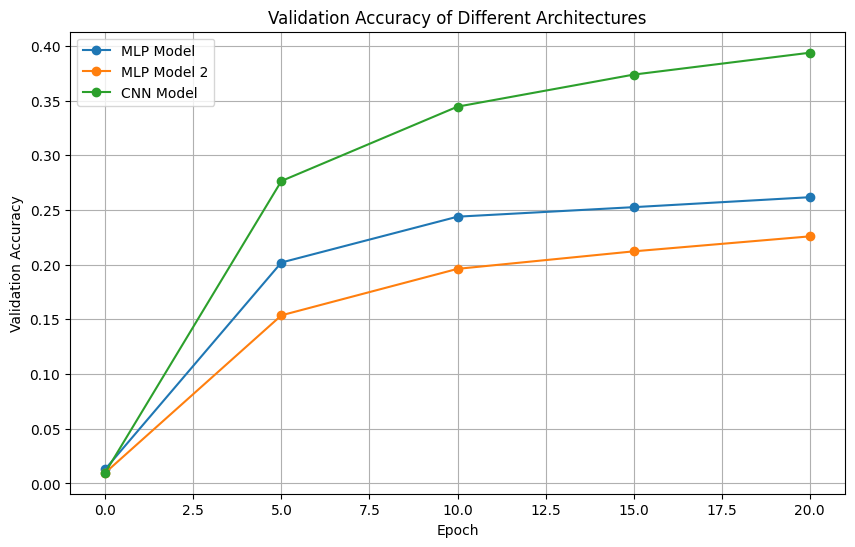

## (b)

From the plot above, CNN model outperforms both MLP models, reaching a validation accuracy of nearly 40% by epoch 20.

**Why did CNN perform better?**

CNNs perform best because they have an inherent inductive bias tailored for image data, specifically shift invariance and local connectivity. CNNs use convolutional filters to capture spatial relationships, allowing them to detect patterns (e.g., edges, textures) anywhere in the image. This weight sharing across the image leads to fewer parameters, better generalization, and the ability to recognize objects regardless of their position (shift invariance). In contrast, MLPs treat each pixel independently, lacking this spatial awareness, resulting in poorer performance for image-related tasks.

**Would arbitrarily deeper MLPs significantly improve accuracy?**

No, arbitrarily deeper MLPs (like the MLP Model 2 in the plot) would not significantly improve validation or test accuracy for the following reasons:

- MLPs cannot capture spatial hierarchies or local patterns in the data, which are essential for images. Deeper MLPs simply add more layers but do not introduce the convolutional layers necessary to handle images effectively.
-  Adding more layers increases the number of parameters, leading to a higher likelihood of overfitting and making the model harder to train without much gain in performance.

# Question 15

## (a)

$$g(h_u) = h_u $$
$$f\left( \sum_{u \in \mathcal{N}(v)} g(h_u) \right) = \frac{1}{|\mathcal{N}(v)|} \sum_{u \in \mathcal{N}(v)} g(h_u) $$


### PyTorch Code Implementation:

```python
import torch
import torch.nn.functional as F

def f(x, num_neighbors):
    # average aggregation
    return x / num_neighbors

def g(x):
    return x

## (b)

$$g(h_u) = \exp(h_u) $$
$$f\left( \sum_{u \in \mathcal{N}(v)} g(h_u) \right) =\log \left( \sum_{u \in \mathcal{N}(v)} g(h_u) \right) $$


### PyTorch Code Implementation:

```python
import torch

def f(x):
    return torch.exp(h_u)

def g(h_u):
    return torch.log(x)

# Question 16

## (a)

Yes,see below discussion of both $generic_f,g$ and $\max$ AGGREGATE function:
1. Generic Aggregation Case:
- **Aggregation**: Define the aggregation function as averaging neighbor features, therefore node features will remain the same during iterations since the initial features are the same
  
- **Update Function**: Can be flexible, such as identity function

- **READOUT Function**: The final **READOUT** can sum the features of all nodes:
  $$
  \text{READOUT} = \frac{\sum_{v \in G} h_v^{(k)}}{\text{mean}(h_v^{(k)})}
  $$
   Since $ \text{mean}(h_v^{(k)}) = h_v $ (as all features are equal), this is equivalent to summing the node features, which gives the total number of nodes.

2. Max Aggregation Case:
- **Aggregation**: Max aggregation results in all nodes having the same feature throughout the iterations since the initial features are the same.
- **Update Function**: Can be flexible, such as identity function

- **READOUT Function**: We can compute the total number of nodes using the following readout:
  $$
  \text{READOUT} = \frac{\sum_{v \in G} h_v^{(k)}}{\text{max}(h_v^{(k)})}
  $$
  Since $ \text{max}(h_v^{(k)}) = h_v $ (as all features are equal), this is equivalent to summing the node features, which gives the total number of nodes.

## (b)

Yes, see discussion below
1. Generic Aggregation Case:
- **Aggregation Functions**:
  - $g(h_u) = h_u + 1 $ (increment distance for neighbors)
  - $ f(x) = \min(x) $ (retain the smallest distance)
  
- **Update Function**: Nodes propagate distance information, and each node updates its feature to the minimum distance from its neighbors. $$h_u^{(k+1)} = \min \left( h_u^{(k)}, \min_{w \in \mathcal{N}(u)} \left( h_w^{(k)} \right) \right) $$

- **Readout Function**:
  $$
  \text{READOUT} = \max_{u \in G} h_u^{(k)}
  $$
  This computes the maximum shortest distance after the final iteration.

2. Max Aggregation Case:
- **Update Function**:
  $$
  h_u^{(k+1)} = \min \left( h_u^{(k)}, \min_{w \in \mathcal{N}(u)} \left( h_w^{(k)} + 1 \right) \right)
  $$
  This ensures that nodes propagate the smallest feature (tracking the shortest distance) and increment the path length at each iteration.

- **Readout Function**:
  $$
  \text{READOUT} = \max_{u \in G} h_u^{(k)}
  $$
  This gives the maximum shortest distance after the final iteration.

## (c)

No, a GNN cannot differentiate between two graphs with the same unrolled tree structures at each node, even if they contain a different number of triangles. This is because GNNs aggregate node features based on local neighborhood information, and if two nodes share identical unrolled tree structures, the GNN will compute the same feature representation for them.See below examples from lecture slides:
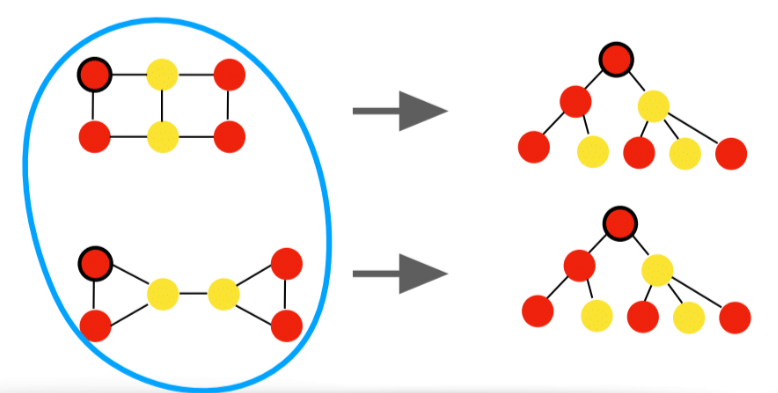
- The two graphs have identical local structures (as seen by their unrolled tree structures), but the upper graph has 0 triangles, while the lower graph has 2 triangles.
Because GNNs cannot differentiate between nodes with the same neighborhood structures, they will treat these two graphs as isomorphic, even though they have a different number of triangles.

# Question 17

## (a)

No, MP-GNNs using the generic aggregation function cannot differentiate between mirror images of chiral molecules. This limitation arises because MP-GNNs operate similarly to the 1-dimensional Weisfeiler-Lehman (WL) test, which is used to determine graph isomorphism. Since the mirror images of chiral molecules have the same local neighborhood structure (i.e., the same unrolled tree structure), the 1-WL algorithm cannot distinguish between them. Therefore, MP-GNNs, which rely on this kind of aggregation, cannot differentiate between such mirror images.

# Question 18

The validation losses are plotted below:
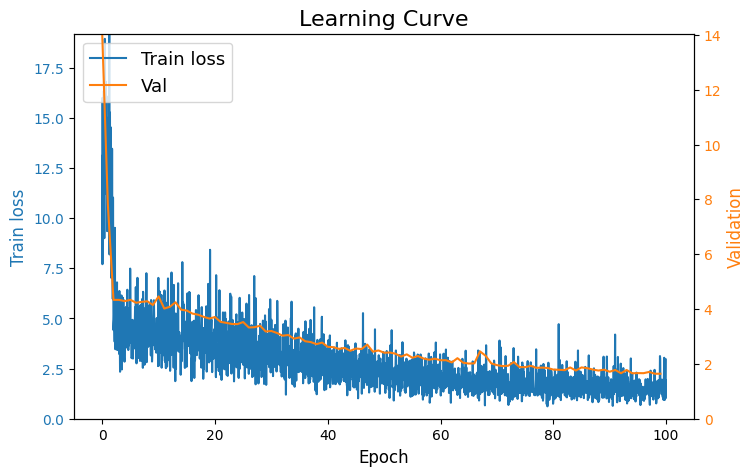